<a href="https://colab.research.google.com/github/ashen-pabasara/speech-emotion-recognition/blob/main/speech_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install required packages**

In [ ]:
!pip install kaggle librosa soundfile tensorflow scikit-learn matplotlib


**Mount Google Drive and Download Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()   # upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

import zipfile

with zipfile.ZipFile("toronto-emotional-speech-set-tess.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/tess")

import os

data_path = "/content/tess"
for root, dirs, files in os.walk(data_path):
    print(root, len(files))
    break


Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97% 417M/428M [00:02<00:00, 129MB/s] 
100% 428M/428M [00:02<00:00, 161MB/s]
/content/tess 0


**EDA**

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

DATASET_PATH = "/content/tess/TESS Toronto emotional speech set data"



**File Counts Per Emotion**

In [ ]:
# File Counts Per Emotion
from collections import Counter

emotion_counts = Counter()

for folder in sorted(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(".wav")]
        emotion = folder.split("_")[-1]
        emotion_counts[emotion] += len(files)

emotion_counts


Counter({'Fear': 200,
         'surprise': 200,
         'Sad': 200,
         'angry': 400,
         'disgust': 400,
         'happy': 400,
         'neutral': 400,
         'fear': 200,
         'surprised': 200,
         'sad': 200})

In [ ]:
def normalize_emotion(label):
    label = label.lower()
    mapping = {
        "fear": "fear",
        "sad": "sad",
        "surprise": "surprise",
        "surprised": "surprise",
        "sad": "sad",
        "fear": "fear",
        "angry": "angry",
        "disgust": "disgust",
        "happy": "happy",
        "neutral": "neutral"
    }
    return mapping.get(label, label)


In [ ]:
from collections import Counter

emotion_counts = Counter()

for folder in sorted(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(".wav")]
        raw_emotion = folder.split("_")[-1]
        emotion = normalize_emotion(raw_emotion)
        emotion_counts[emotion] += len(files)

emotion_counts

Counter({'fear': 400,
         'surprise': 400,
         'sad': 400,
         'angry': 400,
         'disgust': 400,
         'happy': 400,
         'neutral': 400})

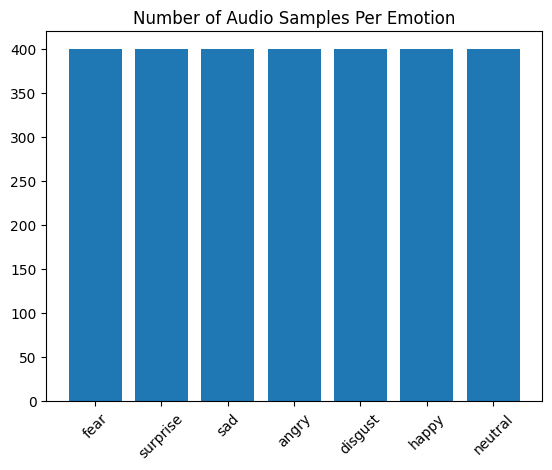

In [ ]:
import matplotlib.pyplot as plt

plt.bar(emotion_counts.keys(), emotion_counts.values())
plt.xticks(rotation=45)
plt.title("Number of Audio Samples Per Emotion")
plt.show()


**Waveform Plots**

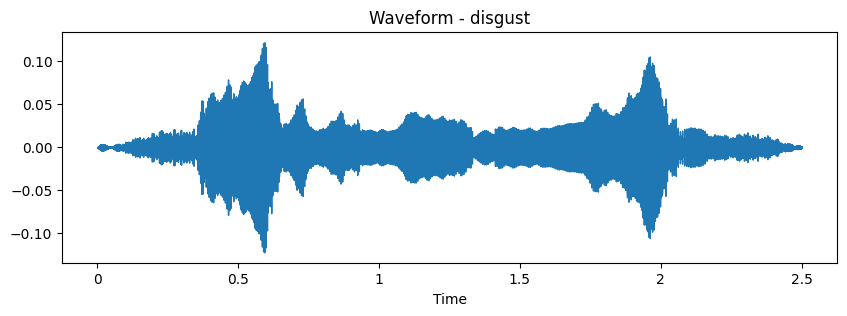

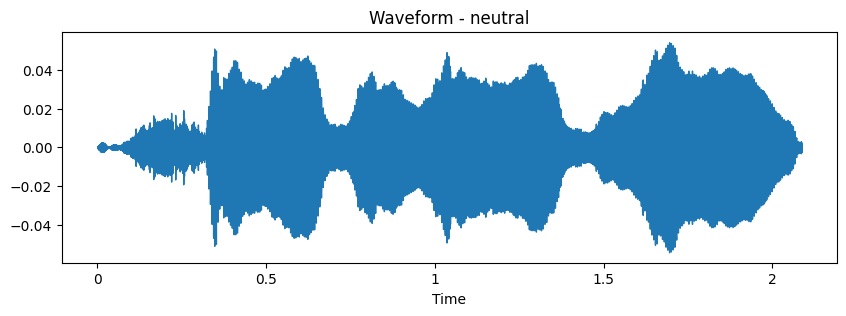

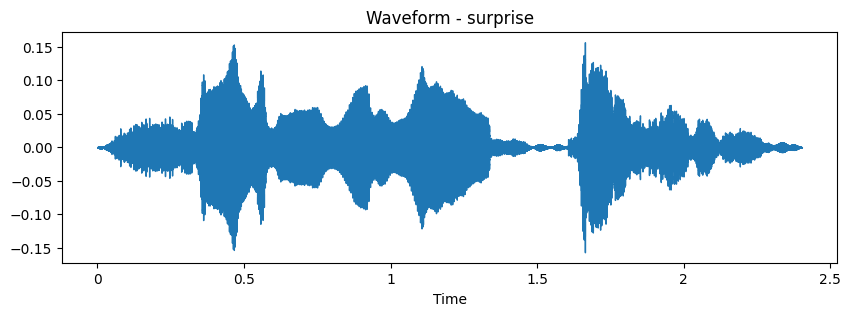

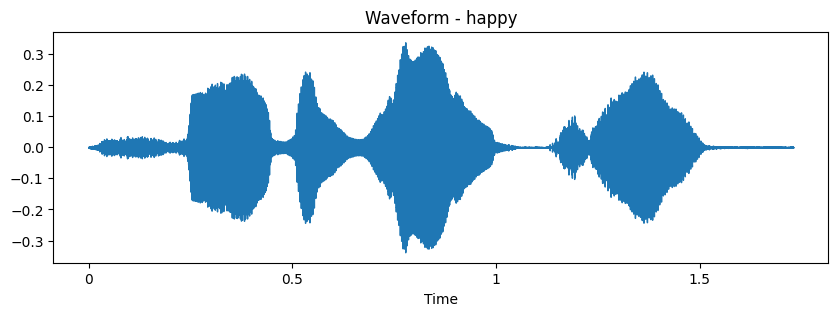

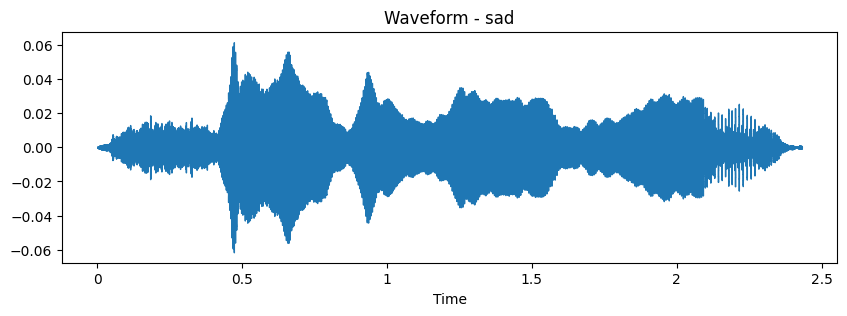

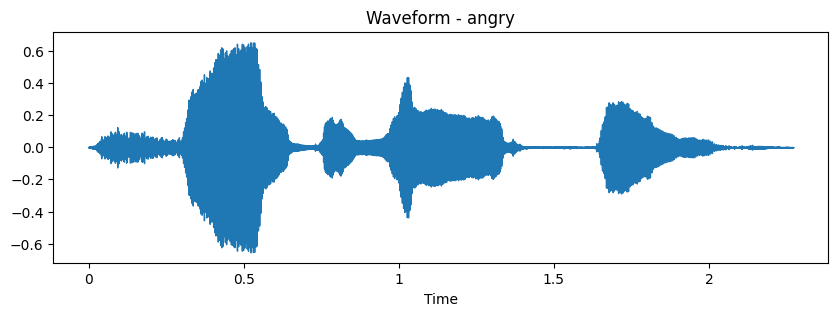

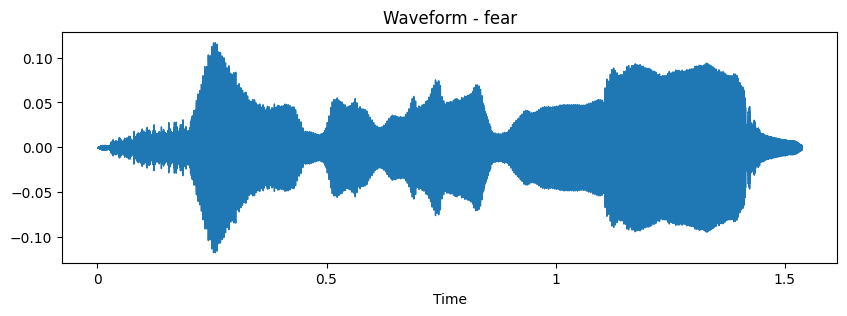

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

sample_files = {}

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
        if files:
            emotion = normalize_emotion(folder.split("_")[-1])
            sample_files[emotion] = os.path.join(folder_path, files[0])

for emotion, file_path in sample_files.items():
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {emotion}")
    plt.show()


**Spectrograms**

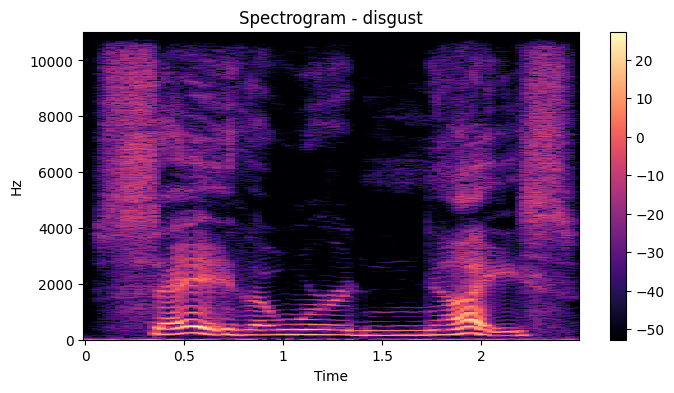

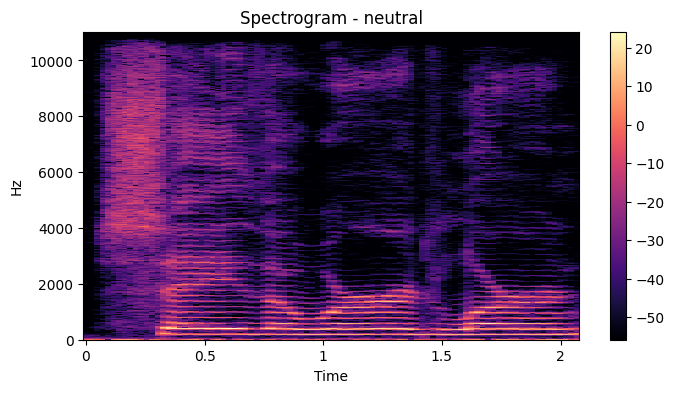

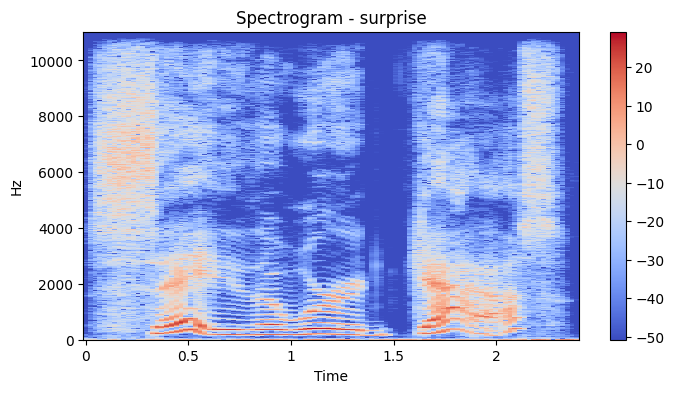

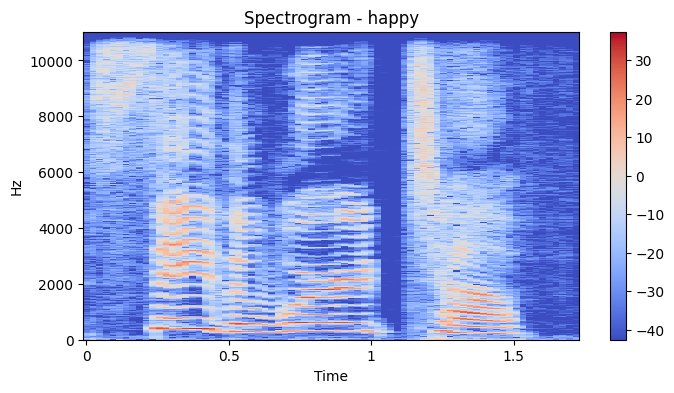

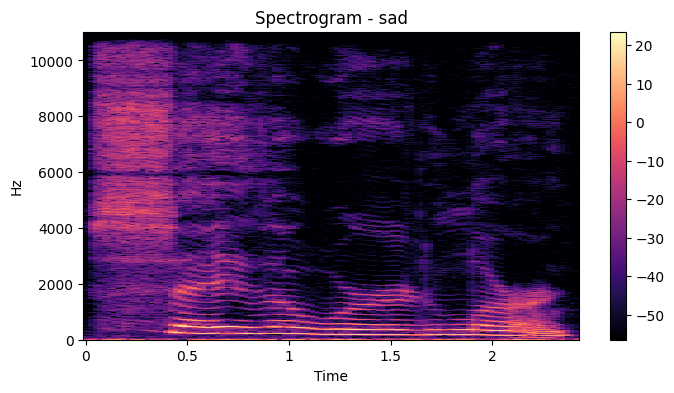

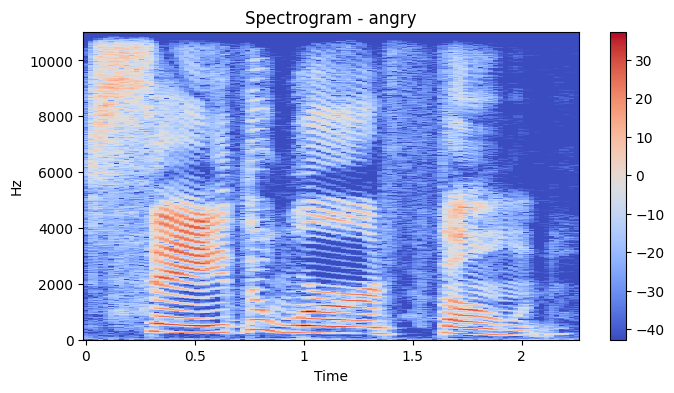

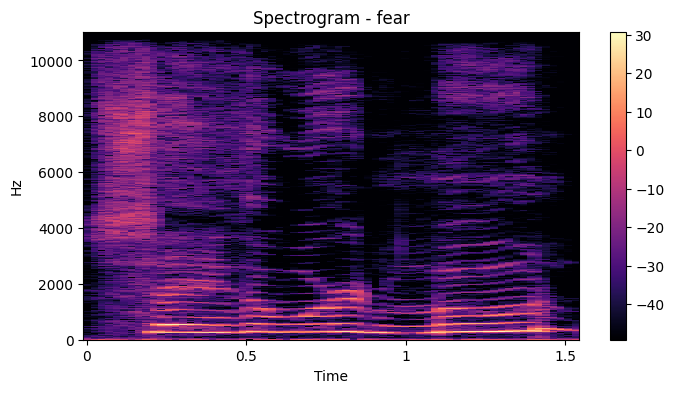

In [ ]:
for emotion, file_path in sample_files.items():
    y, sr = librosa.load(file_path)
    S = librosa.stft(y)
    S_db = librosa.amplitude_to_db(abs(S))

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
    plt.colorbar()
    plt.title(f"Spectrogram - {emotion}")
    plt.show()


**MFCC Heatmaps**

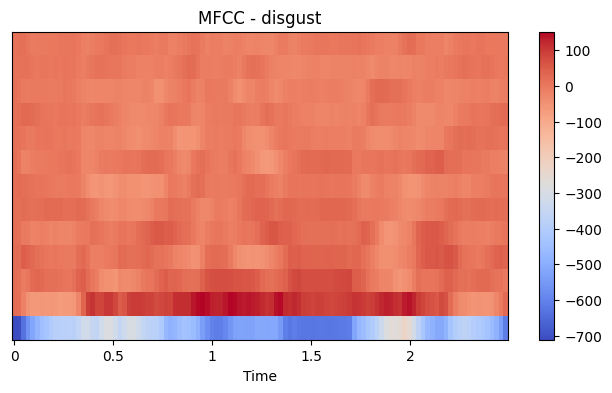

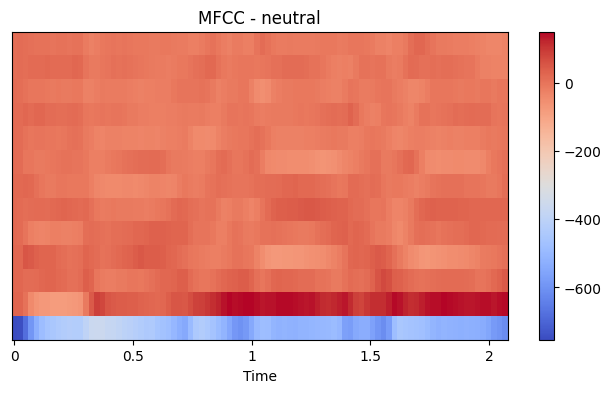

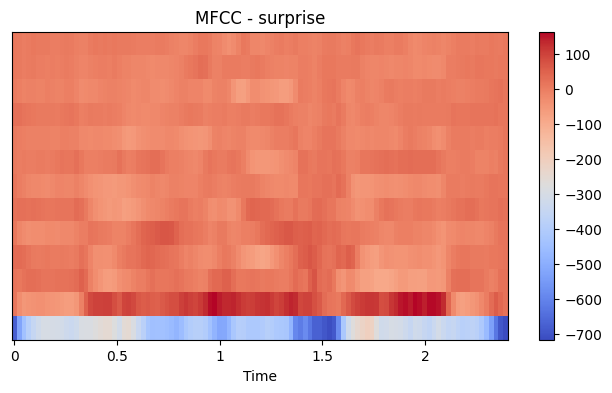

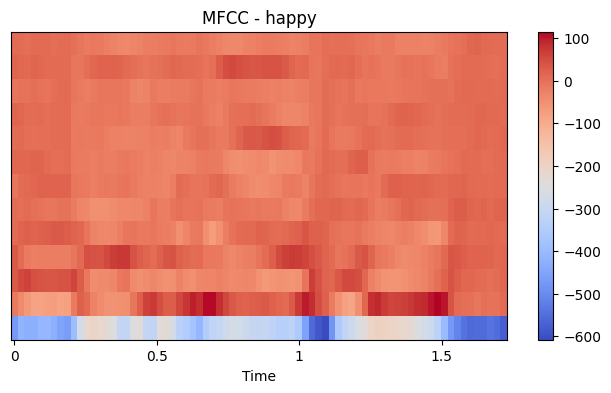

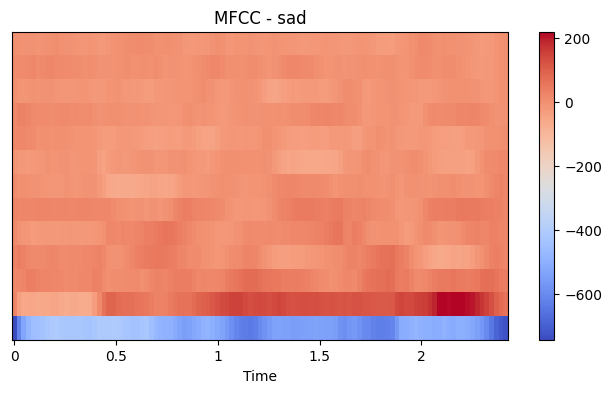

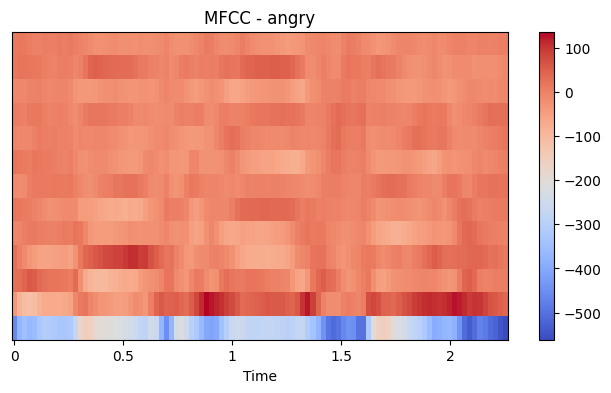

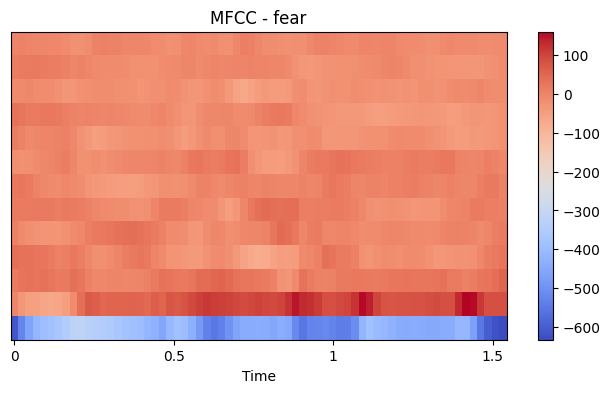

In [ ]:
for emotion, file_path in sample_files.items():
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, x_axis="time")
    plt.colorbar()
    plt.title(f"MFCC - {emotion}")
    plt.show()


**Duration Distribution**

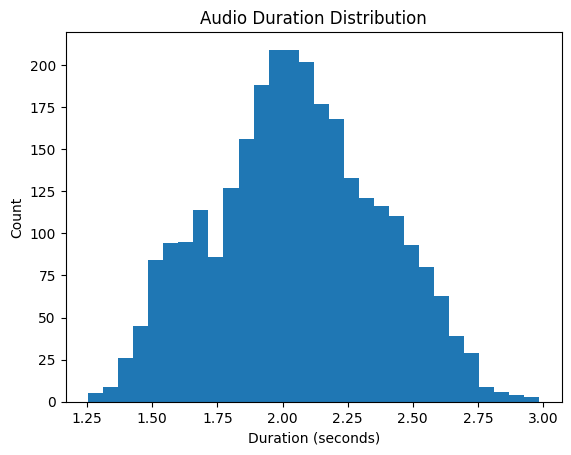

(np.float64(1.2541043083900227),
 np.float64(2.9848072562358277),
 np.float64(2.0551482183349528))

In [ ]:
import numpy as np

durations = []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        for f in os.listdir(folder_path):
            if f.endswith(".wav"):
                y, sr = librosa.load(os.path.join(folder_path, f))
                durations.append(len(y) / sr)

plt.hist(durations, bins=30)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

np.min(durations), np.max(durations), np.mean(durations)


**Statistical Summary of MFCC Features**

In [ ]:
import numpy as np
import pandas as pd

mfcc_features = []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        for f in os.listdir(folder_path):
            if f.endswith(".wav"):
                y, sr = librosa.load(os.path.join(folder_path, f))
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                mfcc_features.append(mfcc_mean)

df_mfcc = pd.DataFrame(mfcc_features, columns=[f"MFCC_{i}" for i in range(1, 14)])
df_mfcc.describe()


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
mean,-406.877960,58.997711,6.704019,8.720278,-2.540251,0.550607,-7.940175,-8.841519,-9.652683,-1.320508,-11.491683,2.342691,-5.182424
std,67.417458,22.343679,15.664834,15.277131,11.532586,7.052860,6.701116,7.935132,6.921431,5.161419,4.663340,6.613575,4.510748
min,-582.485107,-5.788206,-34.013241,-36.367363,-42.819572,-21.298365,-29.745533,-32.080997,-27.359285,-20.521803,-24.681076,-17.416298,-21.861267
25%,-447.301987,41.760273,-6.198972,-3.346882,-10.087314,-4.482101,-12.261694,-14.790441,-15.006566,-4.782946,-14.775305,-2.067245,-7.844117
50%,-407.278854,61.436792,6.172941,8.698130,-1.989797,0.266359,-7.630683,-9.228348,-10.422768,-1.299998,-11.423828,2.770049,-4.596537
75%,-357.912186,76.087490,19.537165,19.507179,4.985417,5.584986,-3.161969,-2.109839,-4.354643,2.295477,-8.402226,7.365648,-2.056293
max,-232.847458,118.675613,46.876213,52.708889,25.684244,19.981615,13.893983,9.489455,11.274470,13.724472,6.256916,19.288847,8.754988


**Correlation Matrix**

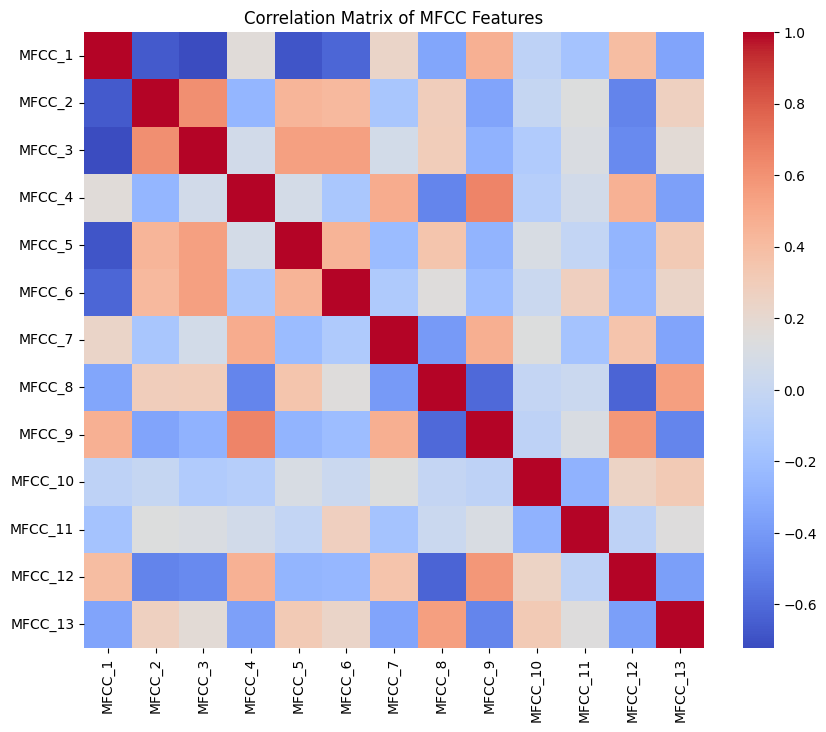

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_mfcc.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix of MFCC Features")
plt.show()


**PCA and t-SNE Clustering Visualization**

In [ ]:
X = []
y = []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        emotion = normalize_emotion(folder.split("_")[-1])
        for f in os.listdir(folder_path):
            if f.endswith(".wav"):
                y.append(emotion)
                y_path = os.path.join(folder_path, f)
                audio, sr = librosa.load(y_path)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                X.append(mfcc_mean)

X = np.array(X)


/tmp/ipython-input-884751416.py:7: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y)[0])


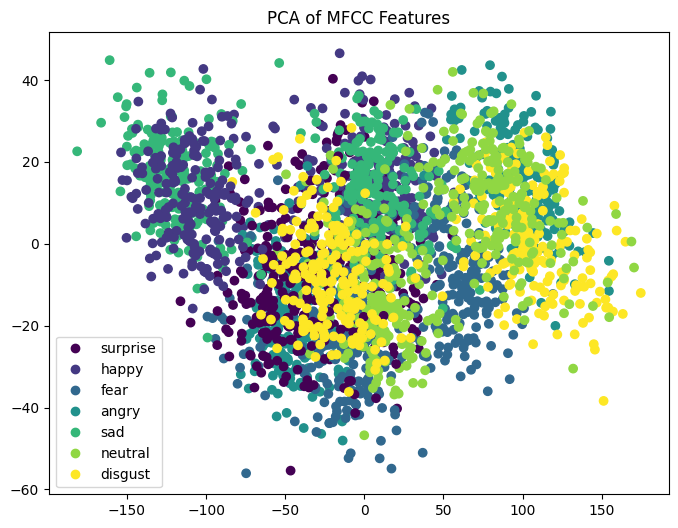

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y)[0])
plt.legend(scatter.legend_elements()[0], list(set(y)))
plt.title("PCA of MFCC Features")
plt.show()


/tmp/ipython-input-1750386155.py:7: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pd.factorize(y)[0])


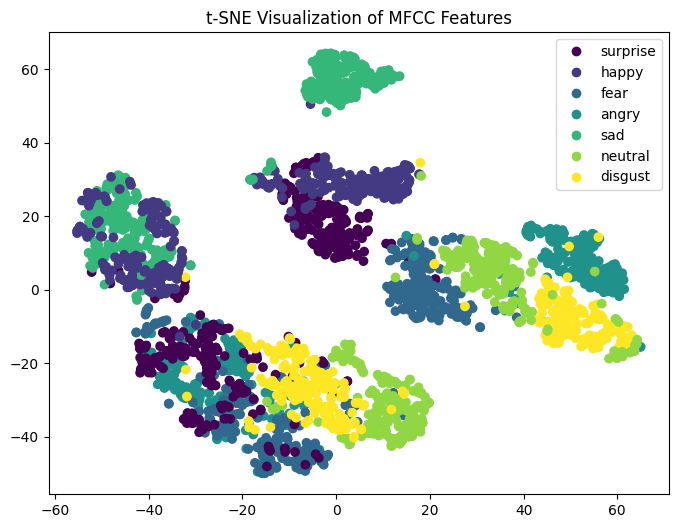

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=pd.factorize(y)[0])
plt.legend(scatter.legend_elements()[0], list(set(y)))
plt.title("t-SNE Visualization of MFCC Features")
plt.show()


**Speaker Bias Analysis**

In [ ]:
speaker_labels = []
X_speaker = []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        speaker = folder.split("_")[0]
        for f in os.listdir(folder_path):
            if f.endswith(".wav"):
                y, _ = librosa.load(os.path.join(folder_path, f))
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)
                X_speaker.append(mfcc_mean)
                speaker_labels.append(speaker)

X_speaker = np.array(X_speaker)


/tmp/ipython-input-404201380.py:4: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  scatter = plt.scatter(X_pca_spk[:, 0], X_pca_spk[:, 1], c=pd.factorize(speaker_labels)[0])


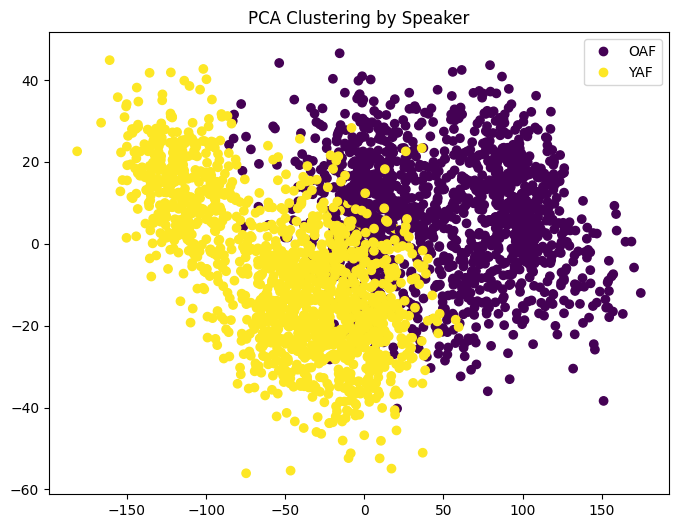

In [ ]:
X_pca_spk = PCA(n_components=2).fit_transform(X_speaker)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_spk[:, 0], X_pca_spk[:, 1], c=pd.factorize(speaker_labels)[0])
plt.legend(scatter.legend_elements()[0], ["OAF", "YAF"])
plt.title("PCA Clustering by Speaker")
plt.show()


In [ ]:
def get_emotion_from_folder(folder):
    return normalize_emotion(folder.split("_")[-1])



**MFCC feature extraction**

In [ ]:
import os
import librosa
import numpy as np

features = []
labels = []

for folder in os.listdir(DATASET_PATH):
    folder_path = os.path.join(DATASET_PATH, folder)

    if os.path.isdir(folder_path):
        emotion = get_emotion_from_folder(folder)

        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)

                signal, sr = librosa.load(file_path, sr=16000)

                mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)

                if mfcc.shape[1] < 150:
                    pad = 150 - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode="constant")
                else:
                    mfcc = mfcc[:, :150]

                features.append(mfcc)
                labels.append(emotion)


In [ ]:
X = np.array(features)
y = np.array(labels)

print("Feature shape:", X.shape)
print("Number of labels:", len(y))
print("Unique labels:", np.unique(y))



Feature shape: (2800, 40, 150)
Number of labels: 2800
Unique labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


**Encode Labels**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

print("Classes:", le.classes_)


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


**Reshape**

In [ ]:
X = X.reshape(X.shape[0], 40, 150, 1)


**Split Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)


Train: (2240, 40, 150, 1)
Test: (560, 40, 150, 1)


**Model Building**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(40,150,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 148, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 148, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 36, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 34, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 34, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 17, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6528)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       835,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 930,183 (3.55 MB)

 Trainable params: 929,735 (3.55 MB)

 Non-trainable params: 448 (1.75 KB)

**Model Training**

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32
)


Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7113 - loss: 1.2945 - val_accuracy: 0.9933 - val_loss: 0.0249
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9872 - loss: 0.0292 - val_accuracy: 0.9911 - val_loss: 0.0242
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9950 - loss: 0.0217 - val_accuracy: 0.9955 - val_loss: 0.0182
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9947 - loss: 0.0210 - val_accuracy: 0.9955 - val_loss: 0.0078
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9987 - loss: 0.0071 - val_accuracy: 0.9978 - val_loss: 0.0102
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9945 - loss: 0.0152 - val_accuracy: 1.0000 - val_loss: 6.9353e-04
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9959 - loss: 0.0092 - val_accuracy: 0.9955 - val_loss: 0.0171
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9978 - va

**Evaluate performance**

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9987 - loss: 0.0109
Test accuracy: 0.9964285492897034


**Confusion matrix**

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step


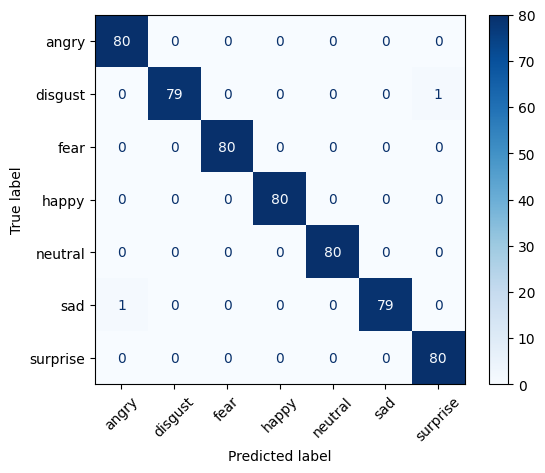

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()


**Save the Model**

In [ ]:
model.save("/content/drive/MyDrive/speech_emotion_cnn.h5")
